#  Comparison of L1 minimization, IHT and NSIHT algorithms for Compressed Sensing 


The algorithms are run for N_mc number of times (no of monte carlo experiments) for different values of m for the measurement matrix. 
This helps us understand the probability of success recovery by calculating the number of succesful recoveries. Similarly, we calculate the relative error for different values of m which shows the different of recovered vector x[n+1] and the true values of the vector x.

import all the libraries required for the project 

In [2]:
import numpy as np
import math
import random
from random import seed
from random import random
from numpy import linalg as LA
import scipy.linalg.interpolative
import random
import matplotlib.pyplot as plt
import cvxpy as cp

Define a function hard_thresh for hard thresholding with the inputs as vector and sparsity. This function returns the s largest absolute values of the vector.

In [3]:
def hard_thresh(x_vec,s):  #input vector x_vec and sparsity level s
    n=len(x_vec) #length of the vector
    val=[]   #empty list to store the indices of s largest elements in x_vec
    
    x_vec_temp=np.array  #store vecor in temporary vector
    x_vec_temp=np.absolute(x_vec)  #store absolute values of vector
    ind=x_vec_temp.argsort(axis=0) #indices of absolute values arranged in order
    
    val=ind[-s:] #indices of s largest values
    
    for i in range(n):
        if i not in val:
            x_vec[i]=0 #values at all indices other than the s largest elements set too zero
      
    return(x_vec)

Define the function that performs l1 minimization. The algorith for l1 minimization is as expalined in the book A Mathematical Introduction to Compressive Sensing by Simon Foucart, Holger Rauhut.


Input: measurement matrix A, measurement vector y.

Instruction: x#= argmin ||z|| subject to Az = y. (BP)

Output: the vector x#

In [4]:
def l1_minimization(m,N,s,N_mc):
    
    probability=[]
    m_val=[]
    diff_l1=[]
    diff_it=[]
    val=[]
    for m in range (20,m,20):
        succ=0  #initialize succesful attempts as 0

        m_val.append(m)  #the vector m_val stores the values of m for every iteration
        
        for i in range(N_mc):  #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
            A=np.random.randn(m,N) 
            x =np.zeros((N,1))

            import random
            randomlist = random.sample(range(0, N-1), s)  # indeces for non zero values

            from random import random

            for i in randomlist:
                x[i]=random()   #putting random non zero, s values to define vector x 

            y=A.dot(x)  # calculating the corresponding vector 

            
            # to solve argmin ||z|| subject to Az = y
            z_n= cp.Variable((N,1))
            z=cp.norm(z_n,1)

            prob = cp.Problem(cp.Minimize(z),[A@z_n==y])  #min  z st A*z_n=y
            prob.solve(abstol=1e-15) 

            z_star=hard_thresh(z_n.value,s) #values for the vector after minimization

            if (LA.norm((x-z_star),2)/LA.norm(x,2))<1e-3: #determinimg success if the values are satisfed
                succ=succ+1

            # finding the difference between actual and calculated values of x to determine relaive error
            diff=z_star-x 
            val.append(LA.norm(diff))
            diff_l1.append(LA.norm(diff))
        
        probability.append(succ/N_mc) #calculating the probability dependig on the number of successful iterations
    
    return m_val,probability,diff_l1     


Define the function iht_algo to describe the IHT algorithm as explained in the paper Iterative hard thresholding for compressed sensing by Thomas Blumensath, Mike E. Davies


Input: measurement matrix A, measurement vector y, sparsity level s.

Initialization: s-sparse vector x0 = 0.

Iteration: repeat the following step until a stopping criterion is met x[n+1] = Hs(x[n]+h A_trans(y-Ax[n]))

Output: the s-sparse vector x[n+1]

In [4]:
def iht_algo (A,y,s,h,max_iter,tol,xn,x,N):
    iteration=0
    rel_incr=10       
    xn1=np.zeros((N,1))  
    
    #the while loop is run till the no of iterations if less than maximum iteration and relative increment greater then the tolerance
    
    while iteration<max_iter and rel_incr>tol:
        
        # x[n+1] = Hs(x[n]+h A_trans(y-Ax[n]))
        A_trans=A.transpose() # A transpose
        xn1=xn+(h*(A_trans.dot((y-(A.dot(xn))))))  #x[n+1]
        xn1=hard_thresh(xn1,s)  #hard threshold for x[n+1]
        
        rel_incr=LA.norm(xn1-xn)/LA.norm(xn1) # realtive increment 
        
        xn=xn1 # replace xn with x[n+1] and continue the loop
           
    return xn

Define the function IHT to perform the IHT algorithm N_mc number of times

In [5]:
def IHT(N,m,s,N_mc):
    prob=[]
    m_val=[]
    diff_iht=[]
    
    for m in range (20,m,20):
        succ=0     #initialize succesful attempts as 0

        for iter_mc in range(N_mc):
            #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
            A=np.random.randn(m,N)  
            x =np.zeros((N,1))
            a=LA.norm(A,2)
            A=A/(a)
            
            import random
            randomlist = random.sample(range(0, N-1), s) # indeces for non zero values
            from random import random
        
            for i in randomlist:
                x[i]=random()   #putting random non zero, s values to define vector x 

            y=A.dot(x)  # calculating the corresponding vector y

            xn=np.zeros((N,1))  # initialize xn as zero vector
            xnplus1=iht_algo(A,y,s,1,100,1e-8,xn,x,N)  #iht algorithm
            
            # finding the difference between actual and calculated values of x to determine relaive error
            diff=xnplus1-x
            diff_iht.append(LA.norm(diff))
        
            if (LA.norm((x-xnplus1),2)/LA.norm(x,2))<1e-3:  #determining the success
                succ=succ+1

        prob.append(succ/N_mc)  #calculating the probability dependig on the number of successful iterations
        
    return prob,diff_iht

Define the function nsiht_algo to explain the NSIHT algorithm as explained in the paper Newton-Step-Based Hard Thresholding Algorithms for Sparse Signal Recovery by Nan Meng and Yun-Bin Zhao




Input: measurement matrix A, measurement vector y, sparsity level s.

Initialization: s-sparse vector x0 = 0.

Iteration: repeat the following step until a stopping criterion is met x[n+1] = Hs(x[n]+h((A_transA+eI)^-1)A_trans(y-Ax[n]))

Output: the s-sparse vector x[n+1]


In [6]:
def nsiht_algo (A,y,s,e,h,max_iter,xn,x,tol,N):
    iteration=0
    rel_incr=10
    
    I=np.identity(N)  #identity matrix
    xn1=np.zeros((N,1)) #initialize x[n+1] as zero vector
    
    #the while loop is run till the no of iterations if less than maximum iteration and relative increment greater then the tolerance  
    while iteration<max_iter and rel_incr>tol:
        
        A_trans=A.transpose()
        inv=(A_trans.dot(A))+(e*I)
        inv=np.linalg.inv(inv) 
        
        #nsiht algorithm
        xn1=xn+(h*inv.dot((A_trans.dot(y-A.dot(xn)))))      
        xn1=hard_thresh(xn1,s)
       
        iteration=iteration+1      
        xn=xn1    # replace xn with x[n+1] and continue the loop
           
    return xn 

Define the function NSIHT to perform the IHT algorithm N_mc number of times

In [7]:
def NSIHT (N,m,s,N_mc):
    prob=[]
    m_val=[]
    diff_nsiht=[]
    for m in range (20,m,20):
        succ=0    #initialize succesful attempts as 0
        
        for iter_mc in range(N_mc):
        #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
        
            A=np.random.randn(m,N)  
            x =np.zeros((N,1))
            a=LA.norm(A,2)
            A=A/(a)
            xminusxnorm=[]
            import random
            randomlist = random.sample(range(0, N-1), s) # indeces for non zero values
            from random import random

            for i in randomlist:
                x[i]=random()    #putting random non zero, s values to define vector x 

            y=A.dot(x)      # calculating the corresponding vector y
            
            xn=np.zeros((N,1))  # initialize vectors x[n] and x[n+1] as zero vector
            xn1=np.zeros((N,1)) 

            x_star=nsiht_algo(A,y,s,1,1,700,xn,x,1e-6,N)   #nsiht algorithm

            if (LA.norm((x-x_star),2)/LA.norm(x,2))<1e-3:  #determining the success
                        succ=succ+1
                    
            # finding the difference between actual and calculated values of x to determine relaive error
            diff=x_star-x
            diff_nsiht.append(LA.norm(diff))
        
        prob.append(succ/N_mc)  #calculating the probability dependig on the number of successful iterations
        
    return prob,diff_nsiht

Define the function recovery_plots to plot the probability of recover for the algorithms vs the value of m

In [8]:
def recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht):
    plt.title('Probability of recovery',fontsize=20)

    # plot the probability of success for the three algorithms vs the values of m to show the probability at different values of m
    plt.plot(m_val,prob_l1)
    plt.plot(m_val,prob_iht)
    plt.plot(m_val,prob_nsiht)


    plt.legend(['L1 min', 'IHT', 'NSIHT'])
    plt.xlabel('m')
    plt.ylabel('recovery probability ')

    plt.show()

Define the function relative_error to plot the difference between the x vector recovered and calculated x for N_mc no of times at the various values of m

In [9]:
def relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m):
    
    #split the values of difference between the vector x calculated and obtained for each iteration, at different values for m as separate lists
    l1_val = [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
    iht_val = [diff_iht[i:i+N_mc] for i in range(0, len(diff_iht), N_mc)]
    nsiht_val = [diff_nsiht[i:i+N_mc] for i in range(0, len(diff_nsiht), N_mc)]
    
    k=len(l1_val) 
    v=[]
    
    for i in range(20,m,20):
        v.append(i) 
        
    j=int(N_mc-1)/2
    j=int(j)
    
    print('\033[1m' +"ERROR IN RECOVERY AT DIFFERENT VALUES FOR m" )
    for i in range(k):
        plt.title( v[i],fontsize=13)    
        plt.plot(l1_val[i])
        plt.plot(iht_val[i])
        plt.plot(nsiht_val[i])
        plt.yscale('log')
        plt.legend(['L1 min', 'IHT', 'NSIHT'])
        plt.ylabel('relative error')
        plt.ylabel('iteratios')
        plt.show()

    

Comparison of algorithms for N_mc=25

In [10]:
m=200
N=200
s=2
N_mc=25

In [11]:
m_val,prob_l1,diff_l1=l1_minimization(m,N,s,N_mc)

C:\Users\Shamita\sd_anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Shamita\sd_anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\S

In [12]:
prob_iht,diff_iht=IHT(m,N,s,N_mc)

In [13]:
prob_nsiht,diff_nsiht=NSIHT(m,N,s,N_mc)

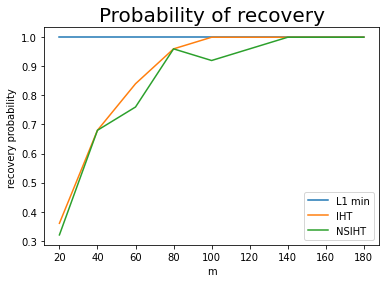

In [14]:
recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht)

ERROR IN RECOVERY AT DIFFERENT VALUES FOR m


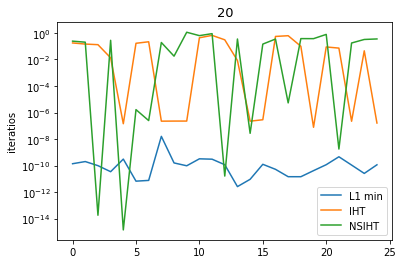

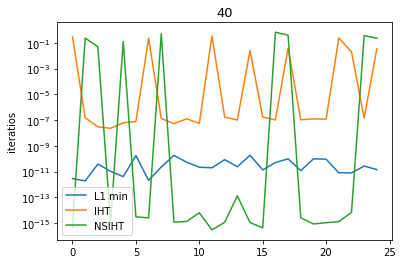

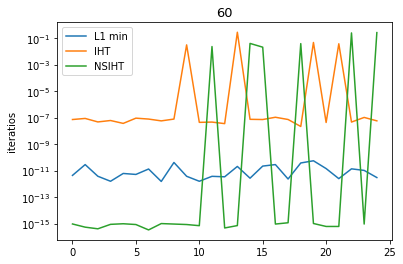

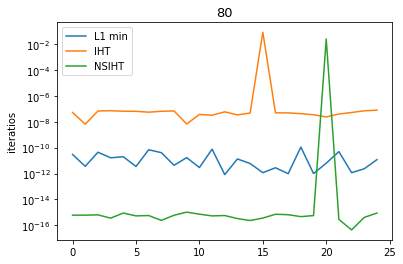

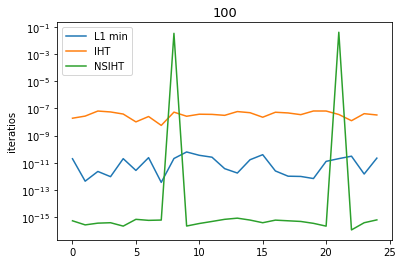

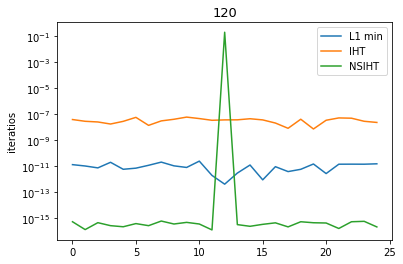

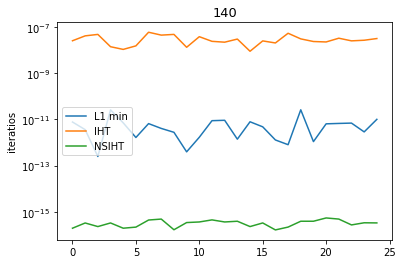

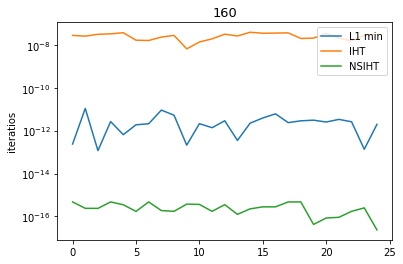

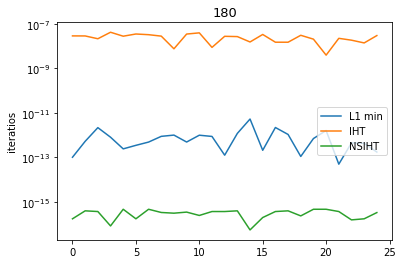

In [15]:
relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m)

Comparison of algorithms for N_mc=50

In [17]:
m=200
N=200
s=2
N_mc=50

In [18]:
m_val,prob_l1,diff_l1=l1_minimization(m,N,s,N_mc)

C:\Users\Shamita\sd_anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 226 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Shamita\sd_anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 227 times so far.

  warnings.warn(msg, UserWarning)
C:\Use

In [19]:
prob_iht,diff_iht=IHT(m,N,s,N_mc)

In [20]:
prob_nsiht,diff_nsiht=NSIHT(m,N,s,N_mc)

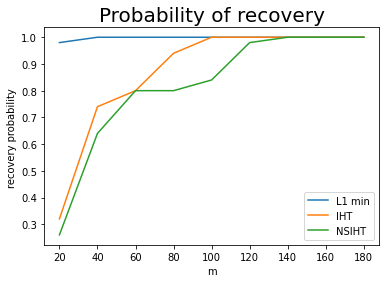

In [21]:
recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht)

ERROR IN RECOVERY AT DIFFERENT VALUES FOR m


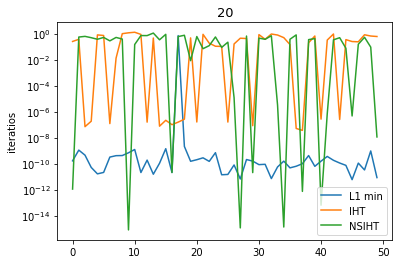

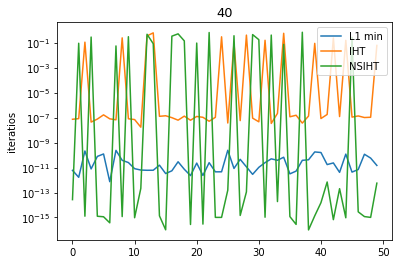

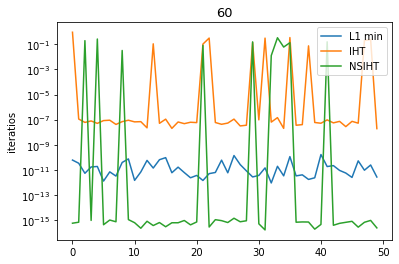

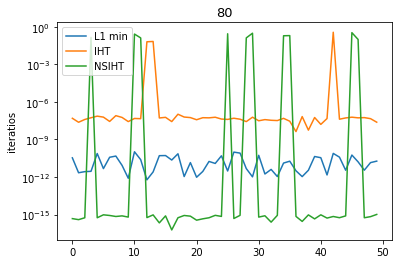

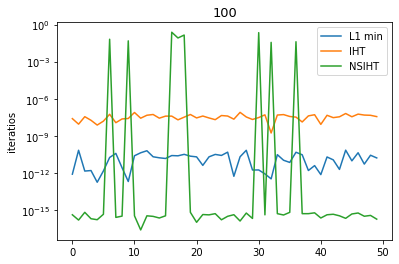

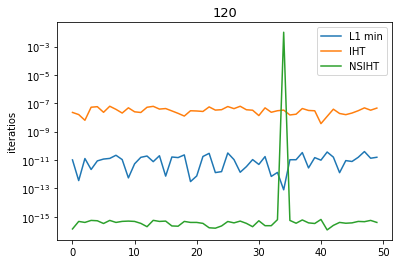

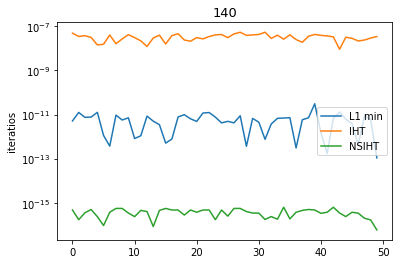

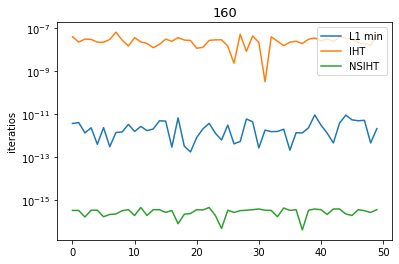

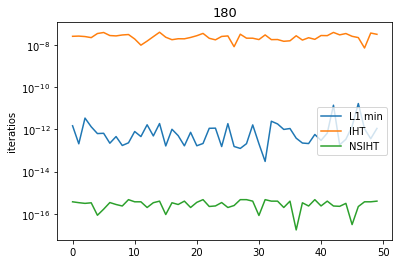

In [22]:
relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m)